# Análisis de N-gramas en Hipnogramas del Sueño

Este notebook proporciona un análisis completo de **n-gramas** (secuencias de n etapas consecutivas) en hipnogramas del sueño.

## ¿Qué son los N-gramas?

Los **n-gramas** son secuencias consecutivas de $n$ etapas del sueño que capturan **patrones temporales** de distintas longitudes.

### Ejemplo:
Para el hipnograma: **[7, 7, 0, 1, 2, 2, 3]**

- **Bigramas (n=2)**: [7→7], [7→0], [0→1], [1→2], [2→2], [2→3]
- **Trigramas (n=3)**: [7→7→0], [7→0→1], [0→1→2], [1→2→2], [2→2→3]
- **4-gramas (n=4)**: [7→7→0→1], [7→0→1→2], [0→1→2→2], [1→2→2→3]

---

## Fórmulas Matemáticas

### Número de N-gramas

Para un hipnograma de longitud $m$ y n-gramas de tamaño $n$:
$$\text{Número de n-gramas} = m - n + 1$$

### Frecuencia de N-gramas

La frecuencia de un n-grama $(e_1 \to e_2 \to ... \to e_n)$ es:
$$f(e_1 \to e_2 \to ... \to e_n) = \frac{\text{count}(e_1 \to e_2 \to ... \to e_n)}{\text{total de n-gramas}}$$

### Selección del Tamaño N

- **n pequeño (2-3)**: Captura transiciones inmediatas, muchos datos
- **n medio (4-6)**: Balance entre contexto y suficiencia de datos
- **n grande (7-10)**: Captura patrones complejos, pocos datos por patrón

**Mi recomendación para hipnogramas**: n=5 captura patrones clínicamente relevantes manteniendo suficientes datos.

---

## Uso del Notebook

Simplemente ejecuta todas las celdas y luego llama a:
```python
# Análisis individual
resultados = generar_reporte_completo("AR_2", n=5)

# Análisis de todos los pacientes
datos_todos = procesar_todos_pacientes(n=5)
```


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style("whitegrid")

## Definición de Funciones


In [2]:
def cargar_hipnograma(archivo):
    """Carga hipnograma y extrae columna de validación"""
    df = pd.read_csv(archivo, sep='\s+', header=None, names=['epoch', 'scor_clean', 'scor_quasi'])
    return df['scor_quasi'].tolist()

def extraer_ngramas(hipnograma, n):
    """
    Extrae n-gramas (secuencias de n etapas consecutivas)
    
    Args:
        hipnograma: lista de etapas del sueño
        n: tamaño del n-grama (2=bigramas, 3=trigramas, etc.)
    
    Returns:
        ngramas: Lista de tuplas (etapa1, etapa2, ..., etapaN)
        ngramas_str: Lista de strings "e1→e2→...→eN"
        num_ngramas: Número total de n-gramas (m-n+1)
    """
    ngramas = []
    ngramas_str = []
    
    for i in range(len(hipnograma) - n + 1):
        ngrama = tuple(hipnograma[i:i+n])
        ngramas.append(ngrama)
        ngramas_str.append("→".join(map(str, ngrama)))
    
    num_ngramas = len(ngramas)
    return ngramas, ngramas_str, num_ngramas

def calcular_frecuencias_ngramas(ngramas):
    """Calcula frecuencias y probabilidades de n-gramas"""
    contador = Counter(ngramas)
    total = len(ngramas)
    
    df = pd.DataFrame([
        {
            'N-grama': "→".join(map(str, ng)),
            'Frecuencia': count,
            'Probabilidad': count/total
        }
        for ng, count in contador.items()
    ])
    
    return contador, df.sort_values('Frecuencia', ascending=False)

def crear_matriz_transiciones_ngramas(ngramas):
    """
    Crea matriz de transición considerando solo la primera y última etapa del n-grama
    
    Para n-grama (e1, e2, ..., en) crea transición e1 → en
    """
    contador = Counter(ngramas)
    
    # Obtener etapas únicas
    etapas = sorted(set([item for ng in ngramas for item in ng]))
    
    # Crear matriz: desde primera etapa del n-grama hacia última etapa
    matriz_abs = pd.DataFrame(0, index=etapas, columns=etapas, dtype=int)
    
    for ngrama, count in contador.items():
        desde = ngrama[0]
        hacia = ngrama[-1]
        matriz_abs.loc[desde, hacia] += count
    
    # Convertir a probabilidades
    matriz_prob = matriz_abs.div(matriz_abs.sum(axis=1), axis=0).fillna(0)
    
    return matriz_abs, matriz_prob

def visualizar_matriz(matriz_prob, titulo):
    """Visualiza matriz con heatmap"""
    mapa = {0: 'Vigilia (W)', 1: 'N1', 2: 'N2', 3: 'N3', 
            4: 'N4', 5: 'REM', 6: 'Movimiento', 7: 'Sin clasificar'}
    labels = [mapa.get(e, f'Etapa {e}') for e in matriz_prob.index.tolist()]
    plt.figure(figsize=(14, 10))
    sns.heatmap(matriz_prob, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.title(f'{titulo}\\nP(etapa final | etapa inicial)', fontsize=14, fontweight='bold')
    plt.ylabel('Etapa Inicial', fontsize=12)
    plt.xlabel('Etapa Final', fontsize=12)
    plt.tight_layout()
    plt.show()

def mostrar_distribucion(hipnograma):
    """Muestra distribución de etapas"""
    dist = Counter(hipnograma)
    df = pd.DataFrame([
        {'Etapa': k, 'Frecuencia': v, 'Porcentaje': v/len(hipnograma)*100} 
        for k, v in sorted(dist.items())
    ])
    nombres = {0: 'Vigilia', 1: 'N1', 2: 'N2', 3: 'N3', 
               4: 'N4', 5: 'REM', 6: 'Movimiento', 7: 'Sin clasificar'}
    print("DISTRIBUCIÓN DE ETAPAS:")
    print(df.to_string(index=False))
    print("\nEtiquetas:")
    for etapa, nombre in nombres.items():
        if etapa in dist:
            print(f"  {etapa}: {nombre}")

def procesar_todos_pacientes(n, ruta_datos='../Datos'):
    """
    Procesa todos los pacientes con n-gramas de tamaño n
    
    Args:
        n: tamaño del n-grama
        ruta_datos: Ruta donde están los archivos de datos
    
    Returns:
        dict con datos consolidados
    """
    import os
    
    archivos = [f for f in os.listdir(ruta_datos) if f.startswith('Scoring_') and f.endswith('_2')]
    pacientes_ids = sorted([f.replace('Scoring_', '').replace('_2', '') for f in archivos])
    
    datos_completos = {}
    lista_metricas = []
    ngramas_todos = []
    
    print(f"Procesando {len(pacientes_ids)} pacientes con {n}-gramas...")
    
    for paciente_id in pacientes_ids:
        archivo = f'{ruta_datos}/Scoring_{paciente_id}_2'
        
        try:
            hipnograma = cargar_hipnograma(archivo)
            ngramas, _, num_ng = extraer_ngramas(hipnograma, n)
            contador, df_freq = calcular_frecuencias_ngramas(ngramas)
            mat_abs, mat_prob = crear_matriz_transiciones_ngramas(ngramas)
            dist = Counter(hipnograma)
            
            ngramas_todos.extend(ngramas)
            
            metricas = {
                'Paciente': paciente_id,
                'Épocas': len(hipnograma),
                'N-gramas': num_ng,
                'N-gramas_únicos': len(contador),
                'Ratio_único/total': len(contador) / num_ng if num_ng > 0 else 0
            }
            
            if len(df_freq) > 0:
                top_ng = df_freq.iloc[0]
                metricas['N-grama_más_freq'] = top_ng['N-grama']
                metricas['Freq_top'] = top_ng['Frecuencia']
                metricas['Prob_top'] = top_ng['Probabilidad']
            
            lista_metricas.append(metricas)
            
            datos_completos[paciente_id] = {
                'hipnograma': hipnograma,
                'ngramas': ngramas,
                'contador': contador,
                'df_frecuencias': df_freq,
                'matriz_absoluta': mat_abs,
                'matriz_probabilidades': mat_prob,
                'distribucion': dict(dist)
            }
            
            print(f"  ✓ {paciente_id}")
            
        except Exception as e:
            print(f"  ✗ Error en {paciente_id}: {e}")
            continue
    
    df_metricas = pd.DataFrame(lista_metricas)
    
    # Matriz promedio
    if datos_completos:
        etapas = sorted(set([item for paciente in datos_completos.values() 
                            for item in paciente['matriz_probabilidades'].index]))
        matriz_promedio = pd.DataFrame(0.0, index=etapas, columns=etapas)
        
        for paciente_data in datos_completos.values():
            mat_prob = paciente_data['matriz_probabilidades']
            for i in etapas:
                for j in etapas:
                    if i in mat_prob.index and j in mat_prob.columns:
                        matriz_promedio.loc[i, j] += mat_prob.loc[i, j]
        
        matriz_promedio = matriz_promedio / len(datos_completos)
    else:
        matriz_promedio = None
    
    print(f"\n✓ Procesamiento completado: {len(datos_completos)} pacientes")
    
    return {
        'dataframe_metricas': df_metricas,
        'datos_completos': datos_completos,
        'matriz_promedio': matriz_promedio,
        'ngramas_todos': ngramas_todos,
        'num_pacientes': len(datos_completos),
        'n': n
    }

def generar_reporte_completo(paciente, n):
    """
    Genera reporte completo para un paciente con n-gramas de tamaño n
    
    Args:
        paciente: ID del paciente (ej: "AR_2")
        n: tamaño del n-grama (2, 3, 4, 5, etc.)
    """
    archivo = f'../Datos/Scoring_{paciente}'
    print(f"ANÁLISIS DE {n}-GRAMAS: PACIENTE {paciente}")
    
    hipnograma = cargar_hipnograma(archivo)
    print(f"{len(hipnograma)} épocas ({len(hipnograma)*0.5:.1f} min)\n")
    
    mostrar_distribucion(hipnograma)
    
    ngramas, ngramas_str, num_ng = extraer_ngramas(hipnograma, n)
    print(f"\n{num_ng} {n}-gramas (m-n+1 = {len(hipnograma)}-{n}+1)\n")
    
    contador, df_freq = calcular_frecuencias_ngramas(ngramas)
    print(f"{len(df_freq)} {n}-gramas únicos\n")
    print("TABLA DE FRECUENCIAS (TODAS)\n")
    print(df_freq.to_string(index=False))
    
    mat_abs, mat_prob = crear_matriz_transiciones_ngramas(ngramas)
    print("\nMATRIZ DE TRANSICIONES (Valores Absolutos)\n")
    print("Nota: Transición desde primera etapa → última etapa del n-grama\n")
    print(mat_abs)
    
    print("\nMATRIZ DE PROBABILIDADES\n")
    print("Interpretación: P(etapa final | etapa inicial)\n")
    print("Filas = inicial, Columnas = final\n")
    print(mat_prob.round(3))
    
    visualizar_matriz(mat_prob, f'Paciente {paciente}: Matriz de {n}-gramas')
    
    print(f"\nPaciente: {paciente}")
    print(f"Épocas: {len(hipnograma)} | {n}-gramas: {num_ng} | Únicos: {len(contador)}")
    print(f"Ratio únicos/total: {len(contador)/num_ng:.3f}")
    
    return {
        'paciente': paciente, 'hipnograma': hipnograma, 'ngramas': ngramas,
        'contador': contador, 'df_frecuencias': df_freq,
        'matriz_absoluta': mat_abs, 'matriz_probabilidades': mat_prob,
        'n': n
    }


## Ejemplo de Uso: Análisis de un Paciente

Analiza un paciente con n-gramas de tamaño configurable. Prueba diferentes valores de **n**:
- **n=2**: Bigramas (transiciones inmediatas)
- **n=3**: Trigramas (captura persistencia)
- **n=5**: Balance óptimo (recomendado)
- **n=10**: Patrones largos (menos datos por patrón)


ANÁLISIS DE 2-GRAMAS: PACIENTE AR_2
977 épocas (488.5 min)

DISTRIBUCIÓN DE ETAPAS:
 Etapa  Frecuencia  Porcentaje
     0           8    0.818833
     1          22    2.251791
     2         482   49.334698
     3          39    3.991812
     4         147   15.046059
     5         231   23.643808
     6          34    3.480041
     7          14    1.432958

Etiquetas:
  0: Vigilia
  1: N1
  2: N2
  3: N3
  4: N4
  5: REM
  6: Movimiento
  7: Sin clasificar

976 2-gramas (m-n+1 = 977-2+1)

29 2-gramas únicos

TABLA DE FRECUENCIAS (TODAS)

N-grama  Frecuencia  Probabilidad
    2→2         436      0.446721
    5→5         224      0.229508
    4→4         137      0.140369
    2→3          20      0.020492
    3→2          16      0.016393
    2→6          16      0.016393
    1→2          15      0.015369
    3→3          13      0.013320
    7→7          13      0.013320
    6→2          11      0.011270
    6→6          10      0.010246
    6→1           9      0.009221
    3→4   

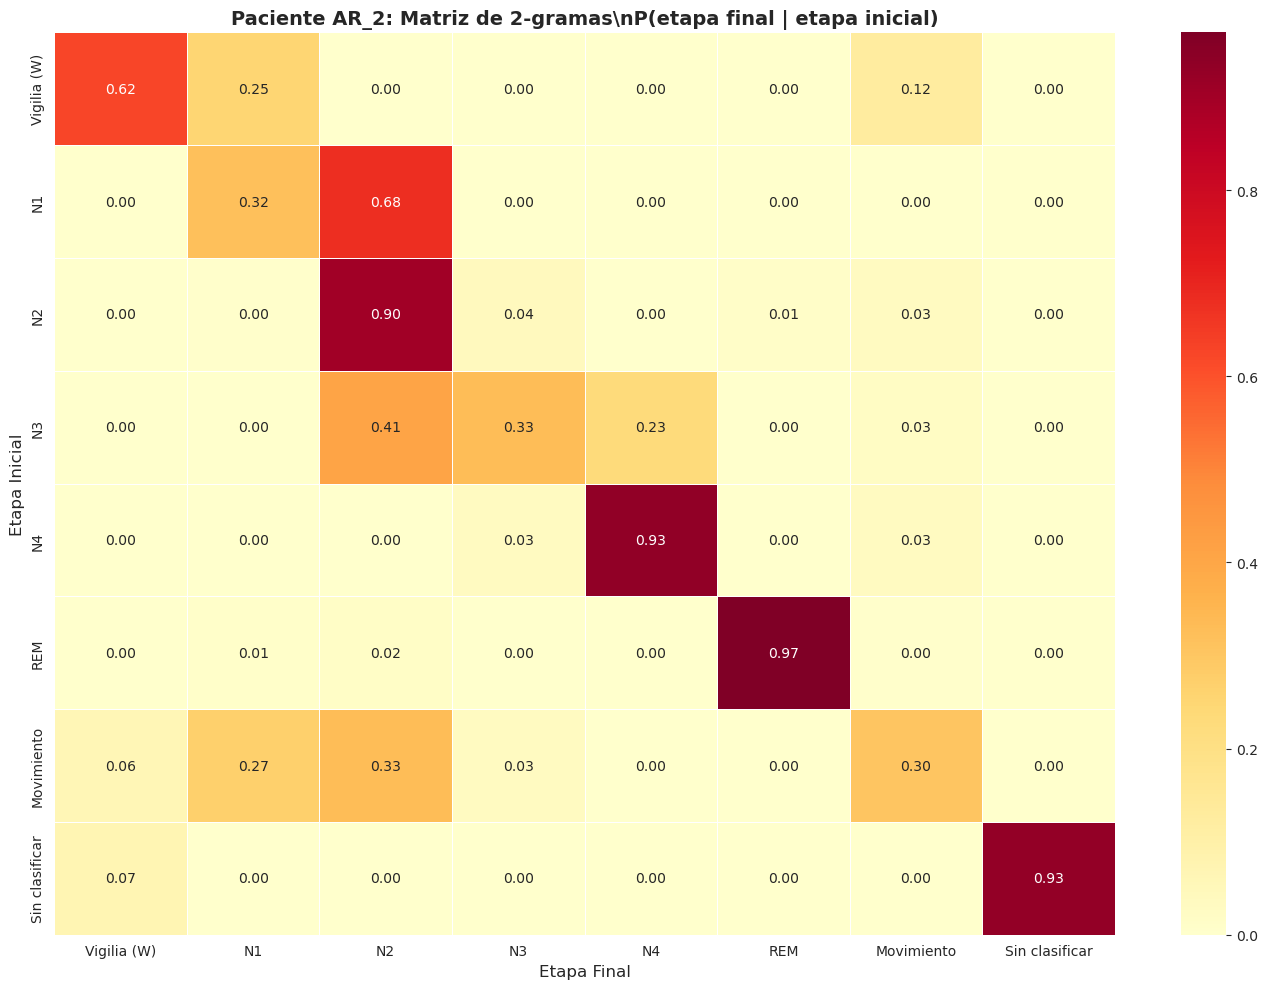


Paciente: AR_2
Épocas: 977 | 2-gramas: 976 | Únicos: 29
Ratio únicos/total: 0.030


In [6]:
# Analizar paciente AR_2 con 5-gramas (recomendado)
resultados = generar_reporte_completo("AR_2", n=2)

## Procesar Todos los Pacientes

Procesa todos los pacientes con n-gramas del tamaño especificado.


In [4]:
# Procesar todos los pacientes con 5-gramas
datos_todos = procesar_todos_pacientes(n=2)

# Ver métricas consolidadas
print("\nMÉTRICAS DE TODOS LOS PACIENTES:")
print(datos_todos['dataframe_metricas'])

# Ver matriz promedio
print("\nMATRIZ DE TRANSICIÓN PROMEDIO:")
print(datos_todos['matriz_promedio'].round(3))


Procesando 10 pacientes con 2-gramas...
  ✓ AR
  ✓ DG
  ✓ EL
  ✓ GA
  ✓ IN
  ✓ JS
  ✓ LL
  ✓ SS
  ✓ VB
  ✓ VC

✓ Procesamiento completado: 10 pacientes

MÉTRICAS DE TODOS LOS PACIENTES:
  Paciente  Épocas  N-gramas  N-gramas_únicos  Ratio_único/total  \
0       AR     977       976               29           0.029713   
1       DG    1055      1054                1           0.000949   
2       EL     947       946               34           0.035941   
3       GA    1023      1022               32           0.031311   
4       IN     981       980               33           0.033673   
5       JS    1042      1041               30           0.028818   
6       LL     894       893               34           0.038074   
7       SS     906       905               30           0.033149   
8       VB     836       835               29           0.034731   
9       VC     840       839                1           0.001192   

  N-grama_más_freq  Freq_top  Prob_top  
0              2→2      